In [1]:
using LinearAlgebra
using QuantumInformation
using Plots
using ProgressBars
using DataFrames
using CSV
using Random

In [2]:
# Set the seed for reproducibility
Random.seed!(123)

TaskLocalRNG()

# Multi-threading

In [3]:
println(Threads.nthreads())

6


In [4]:
a=zeros(10)
Threads.@threads for i = 1:10
           a[i] = Threads.threadid()
       end

In [5]:
a

10-element Vector{Float64}:
 4.0
 4.0
 2.0
 2.0
 1.0
 1.0
 5.0
 5.0
 6.0
 3.0

# Functions

In [6]:
function fully_connected_coupling_matrix(N)
    """Return the coupling matrix for a fully connected reservoir where all N qubits interact.
    
        Args:
            N (int): Number of qubits in reservoir
        Returns:
            J (Matrix): Coupling matrix
    """
    J = rand(N, N)

    # Set diagonal elements for zero (no self-interaction)
    for i in 1:N
        J[i, i] = 0
    end

    return J
end


function commutator(A,B,kind)
    comm=0
    if kind=="anti"
        comm=A*B+B*A
    elseif kind=="normal"
        comm=A*B-B*A
    end
end


function total_rho(interface_rho, reservoir)
    """Return the initial density matrix of the system given the interface as a dnsity matrix"""
    placeholder=reservoir[1]
    for ii in 2:length(reservoir)
        placeholder=kron(placeholder, reservoir[ii])
    end
    rhoR=placeholder*placeholder' #' is the conjugate transpose in Julia
    #Final tensor 
    rho=kron(interface_rho, rhoR)
end 


function ptb(rho)
    """Return the partial transpose of rho about subsystem B for a 4x4 density matrix"""
    a=zeros(Complex{Float64},(length(rho[:,1]), length(rho[:,1])))
    a[1:2,1:2]=transpose(rho[1:2,1:2])
    a[1:2,3:4]=transpose(rho[1:2,3:4])
    a[3:4,1:2]=transpose(rho[3:4,1:2])
    a[3:4,3:4]=transpose(rho[3:4,3:4])
    return a
end


function tr2(rho)
    """Return the purity of rho"""
    pur=real(tr(rho^2))
end


function linear_entropy(rho)
    """Calculate the linear entropy of the given density matrix"""
    N=length(rho[:,1])
    le=(N/(N-1)) * (1-tr2(rho))
end


function gen_purestate(N)
    """Return an NxN density matrix for a random pure state"""
    #Generatte a random complex Nx1 vector 
    p=rand(ComplexF64, N) - rand(ComplexF64, N)
    #Normalise the vector 
    normalize!(p)
    #Generate the density matrix
    dens=p*p'
end


function gen_mixedstate(N)
    """Return an NxN density matrix for a random mixed state"""
    m=rand(Complex{Float64}, (N,N))-rand(Complex{Float64}, (N,N))
    #Normalise 
    M_dens=(m*m')/tr(m*m')
end 


function gen_entangled(N)
    """Return an NxN density matrix for a random entangled system"""
    #Define local variables to function
    temp=Array{ComplexF64,(N,N)}[]
    eigenvalues=zeros(N)
    
    while minimum(eigenvalues)>=0
        #Generate a random mixedstate
        temp=gen_mixedstate(N)
        #Perform the partial transpose 
        ptm=ptb(temp)
        #Find the eigenvalues 
        eigenvalues=real(eigvals(ptm))
    end 
    return temp, minimum(eigenvalues), linear_entropy(temp)
end


function gen_pure_entangled(N)
    """Generate a pure NxN entangled state"""
    temp=zeros(N,N)im
    eigenvalues=zeros(N)
    #Enforce the eigenvalues of the PT must be negative so system is entangled 
    while minimum(eigenvalues)>=0
        #Generate the random purestate
        temp=gen_purestate(N)
        PT=ptb(temp)
        eigenvalues=real(eigvals(PT))
    end
    return temp, minimum(eigenvalues), linear_entropy(temp)
end


function gen_separable(N)
    """Return a separable density matrix"""
    #Define the local variables 
    temp=Array{ComplexF64, (N,N)}[]
    eigenvalues=zeros(N)
    
    #Generate the random mixedstate
    temp=gen_mixedstate(N)
    #Find the partial transpose 
    ptm=ptb(temp)
    #Find the eigenvalues of the PT
    eigenvalues=real(eigvals(ptm))
    #Enforce that the eigenvalues of the PT must be positive
    while minimum(eigenvalues)<=0
        p=rand(Float64) #Random number (0,1]
        temp=p*temp + 0.25*(1-p)*I(4)
        ptm=ptb(temp)
        eigenvalues=real(eigvals(ptm))
    end
    return temp, minimum(eigenvalues), linear_entropy(temp)
end


function gen_pure_separable(N)
    """Return a separable density matrix beginning from a pure state"""
    #Define the local variables 
    temp=Array{ComplexF64, (N,N)}[]
    eigenvalues=zeros(N)
    
    #Generate the random mixedstate
    temp=gen_purestate(N)
    #Find the partial transpose 
    ptm=ptb(temp)
    #Find the eigenvalues of the PT
    eigenvalues=real(eigvals(ptm))
    #Enforce that the eigenvalues of the PT must be positive
    while minimum(eigenvalues)<=0
        p=rand(Float64) #Random number (0,1]
        temp=p*temp + 0.25*(1-p)*I(4)
        ptm=ptb(temp)
        eigenvalues=real(eigvals(ptm))
    end
    return temp, minimum(eigenvalues), linear_entropy(temp)
end 
    
    
function cascade(rho, interface_vector, gamma_vector)
    """Generate the cascade term for the dynamics from interface to specified reservoir qubits"""
    #Define the needed Pauli Matrices first 
    global sigmam=[0 0 ; 1 0]
    global sigmap=[0 1 ; 0 0]
    #Define the local variables
    interface_m=zeros(2,2)
    interface_p=zeros(2,2)
    N_int=length(interface_vector)
    sig_I_minus=Matrix{ComplexF64}
    sig_I_plus=Matrix{ComplexF64}
    sig_pos_list=Matrix{ComplexF64}
    sig_minus_list=Matrix{ComplexF64}
    cas=zeros(length(rho[:,1]),length(rho[:,1]))
    
    #Interface vector is boolean indicating if interface qubit should connect to reservoir
    if interface_vector[1]==0
        interface_m=I(2) #Identity matrix
        interface_p=I(2)
    elseif interface_vector[1]==1
        interface_m=sigmam
        interface_p=sigmap
    end 
    #Populate the rest of the matrices for the operators 
    for ii in 2:length(interface_vector)
        if interface_vector[ii]==0
            interface_m=interface_m⊗I(2)
            interface_p=interface_p⊗I(2)
        elseif interface_vector[ii]==1
            interface_m=interface_m⊗sigmam
            interface_p=interface_p⊗sigmap
        end
    end
    
    #Begin on the reservoir terms 
    #Include a clause for the 1 qubit case 
    if length(gamma_vector)==1
        sig_I_minus=interface_m⊗I(2)
        sig_I_plus=interface_p⊗I(2)
        sig_1_minus=I(2^N_int)⊗sigmam
        sig_1_plus=I(2^N_int)⊗sigmap
        cas=gamma_vector[1]*(commutator(sig_I_minus*rho,sig_1_plus,"normal")+
        commutator(sig_1_minus,rho*sig_1_plus,"normal"))
    
    else
        #Generate the needed pauli operators in system size 
        sig_I_minus=interface_m⊗I(convert(Int,(length(rho[:,1])/(2^N_int))))
        sig_I_plus=interface_p⊗I(convert(Int,(length(rho[:,1])/(2^N_int))))
        sig_pos_list=zeros(2^(length(gamma_vector)+N_int),
        2^(length(gamma_vector)+N_int),
        length(gamma_vector))
        sig_minus_list=zeros(2^(length(gamma_vector)+N_int),
        2^(length(gamma_vector)+N_int),
        length(gamma_vector))
        
        #Populate the operator list for the reservoir with the first and last elements first 
        sig_pos_list[:,:,1]=I(2^N_int)⊗(sigmap⊗I(2^(length(gamma_vector)-1)))
        sig_minus_list[:,:,1]=I(2^N_int)⊗(sigmam⊗I(2^(length(gamma_vector)-1)))
        sig_pos_list[:,:,end]=I(2^N_int)⊗(I(2^(length(gamma_vector)-1))⊗sigmap)
        sig_minus_list[:,:,end]=I(2^N_int)⊗(I(2^(length(gamma_vector)-1))⊗sigmam)
        #Populate intermediary terms if needed 
        if length(gamma_vector)>2
            for ii in 2:(length(gamma_vector)-1)
                sig_pos_list[:,:,ii]=I(2^N_int)⊗I(2^(ii-1))⊗sigmap⊗I(2^(length(gamma_vector)-ii))
                sig_minus_list[:,:,ii]=I(2^N_int)⊗I(2^(ii-1))⊗sigmam⊗I(2^(length(gamma_vector)-ii))
            end
        end

        #Populate the cascade terms for this situation
        for ii in 1:length(gamma_vector)            
            cas+=gamma_vector[ii]*(commutator(sig_I_minus*rho, sig_pos_list[:,:,ii], "normal")+
            commutator(sig_minus_list[:,:,ii], rho*sig_I_plus, "normal"))
        end
    end
    return cas
end
        

function dissipate(rho, interface_vector, gamma_D)
    """Dissipation for each interface qubit to ensure physicality"""
    #Define the local variables 
    interface_m=Matrix{ComplexF64}
    interface_p=Matrix{ComplexF64} 
    sig_I_minus=Matrix{ComplexF64} 
    sig_I_plus=Matrix{ComplexF64} 
    diss=zeros(length(rho[:,1]), length(rho[:,1]))
    N_int=length(interface_vector)
    
    #Generate the interface operators 
    if interface_vector[1]==0
        interface_m=I(2) #Identity matrix
        interface_p=I(2)
    elseif interface_vector[1]==1
        interface_m=sigmam
        interface_p=sigmap
    end 
    #Populate the rest of the matrices for the operators 
    for ii in 2:length(interface_vector)
        if interface_vector[ii]==0
            interface_m=interface_m⊗I(2)
            interface_p=interface_p⊗I(2)
        elseif interface_vector[ii]==1
            interface_m=interface_m⊗sigmam
            interface_p=interface_p⊗sigmap
        end
    end
    
    #Define the needed Pauli Operators
    sig_I_minus=interface_m⊗I(convert(Int, (length(rho[:,1])/(2^N_int))))
    sig_I_plus=interface_p⊗I(convert(Int, (length(rho[:,1])/(2^N_int))))
    
    #Generate the dissipation term using anticommutators for the Lindblad equation
    diss=gamma_D*(2*sig_I_minus*rho*sig_I_plus - commutator(sig_I_plus*sig_I_minus, rho, "anti"))
end


function hamiltonian_R(rho, J_matrix)
    """Return the Hamiltonian of the reservoir given the coupling between qubits"""
    #Initialise the local variables
    N=convert(Int,log2(length(rho[:,1]))) #Dimension of the whole system
    N_res=convert(Int,length(J_matrix[:,1])) #Dimension of the reservoir 
    N_int=convert(Int,log2(length(rho[:,1]))-length(J_matrix[:,1])) #Dimension of the interface
    H_R=zeros(2^N_res,2^N_res) 
    sig_pos_list=zeros(2^N_res, 2^N_res, N_res) #Operators for the Hamiltonian
    sig_minus_list=zeros(2^N_res, 2^N_res, N_res)
    
    #Populate the operator list 
    sig_pos_list[:,:,1]=sigmap⊗I(2^(N_res-1))
    sig_minus_list[:,:,1]=sigmam⊗I(2^(N_res-1))
    sig_pos_list[:,:,end]=I(2^(N_res-1))⊗sigmap
    sig_minus_list[:,:,end]=I(2^(N_res-1))⊗sigmam
    #Any interior terms
    if N_res>2
        for ii in 2:(N_res-1)
            sig_pos_list[:,:,ii]=I(2^(ii-1))⊗sigmap⊗I(2^(N_res-ii))
            sig_minus_list[:,:,ii]=I(2^(ii-1))⊗sigmam⊗I(2^(N_res-ii))
        end
    end
    
    #Populate the hamiltonian matrix
    for ii in 1:N_res
        for jj in 1:N_res
            H_R+=J_matrix[ii,jj]*(sig_pos_list[:,:,ii]*sig_minus_list[:,:,jj]+sig_pos_list[:,:,jj]*sig_minus_list[:,:,ii])
        end
    end
    
    #Now tensor with identity of interface to match system size
    H_R=I(2^N_int)⊗H_R
end


function connect_interface(rho0, times, gamma_C, gamma_D, interface_vector)
    """Connect the interface and reservoir and return density tensor in time"""
    #Initialise the local variables 
    dens_tensor=zeros(length(rho0[:,1]), length(rho0[:,1]), length(times))im
    #Set the first term 
    dens_tensor[:,:,1]=rho0
    #Find the time separation 
    dt=times[2]-times[1]

    #Evolve using Runge-Kutta O(dt^4) method
    for ii in 2:length(times)
        #Determine the Runge-Kutta terms 
        k1=(cascade(dens_tensor[:,:,ii-1], interface_vector, gamma_C)+
            dissipate(dens_tensor[:,:,ii-1], interface_vector, gamma_D))*dt
        k2=(cascade((dens_tensor[:,:,ii-1]+0.5*k1), interface_vector, gamma_C)+
            dissipate((dens_tensor[:,:,ii-1]+0.5*k1), interface_vector, gamma_D))*dt
        k3=(cascade((dens_tensor[:,:,ii-1]+0.5*k2), interface_vector, gamma_C)+
            dissipate((dens_tensor[:,:,ii-1]+0.5*k2), interface_vector, gamma_D))*dt
        k4=(cascade((dens_tensor[:,:,ii-1]+k3), interface_vector, gamma_C)+
            dissipate((dens_tensor[:,:,ii-1]+k3), interface_vector, gamma_D))*dt
        #Solve the Taylor expansion
        dens_tensor[:,:,ii]=dens_tensor[:,:,ii-1] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    end 
    return dens_tensor
end


function reservoir_dynamics(rho0, times, J_matrix, interface_vector)
    """Evolve the dynamics inside the reservoir after transfer of excitation"""
    #Initialise the local variables 
    dens_tensor=zeros(length(rho0[:,1]), length(rho0[:,1]), length(times))im
    #Set the first term 
    dens_tensor[:,:,1]=rho0
    #Find the time separation 
    dt=times[2]-times[1]
    
    #Solve the SE with Runge-Kutta O(dt^4) methods
    for ii in 2:length(times)
        #Determine the Runge-Kutta terms 
        k1=(-im * commutator(hamiltonian_R(dens_tensor[:,:,ii-1], J_matrix), dens_tensor[:,:,ii-1], "normal"))*dt
        k2=(-im * commutator(hamiltonian_R(dens_tensor[:,:,ii-1], J_matrix), (dens_tensor[:,:,ii-1]+0.5*k1), "normal"))*dt
        k3=(-im * commutator(hamiltonian_R(dens_tensor[:,:,ii-1], J_matrix), (dens_tensor[:,:,ii-1]+0.5*k2), "normal"))*dt
        k4=(-im * commutator(hamiltonian_R(dens_tensor[:,:,ii-1], J_matrix), (dens_tensor[:,:,ii-1]+k3), "normal"))*dt
        #Solve the Taylor expansion 
        dens_tensor[:,:,ii]=dens_tensor[:,:,ii-1] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    end
    return dens_tensor
end


function reduced_density_matrix(rho, qubit)
    """Return the reduced density matrix for the wanted qubit out of rho"""
    #Total number of qubits of the system 
    N=length(rho[:,1])
    #Find the dimension of the system leading up to the wanted qubit
    N_before=2^(qubit-1)
    #The dimension of the system after the wanted qubit 
    N_after=convert(Int, N/2^(qubit))
    #Find the reduced density matrix
    rd=ptrace(rho, [N_before,2,N_after],[1,3])
end


function sig_z_exp(rho, qubit)
    """Give the expectation value of σz for a given qubit"""
    #Define the needed Pauli Operator 
    sigmaz=[1 0 ;
            0 -1]
    #Find the reduced density matrix of the wanted qubit 
    rho_q=reduced_density_matrix(rho, qubit)
    #Find the expectation value 
    exp=real(tr(sigmaz*rho_q))
end


function reservoir_excitations(N, J_matrix, gamma_C, gamma_D, cascade_time, reservoir_time, dt, reservoir_state, interface)
    global data=zeros(4,4,N)im
    global labels=zeros(2,N)

    #Eigenvalue and linear entropy will both be computed as labels 
    for ii in 1:convert(Int,N/4)
        temp=gen_separable(4)
        data[:,:,ii]=temp[1]
        labels[1,ii]=temp[2]
        labels[2,ii]=temp[3]
    end
    for ii in convert(Int, N/4):convert(Int,N/2)
        temp=gen_pure_separable(4)
        data[:,:,ii]=temp[1]
        labels[1,ii]=temp[2]
        labels[2,ii]=temp[3]
    end
    for ii in convert(Int,N/2):convert(Int,3N/4)
        temp=gen_entangled(4)
        data[:,:,ii]=temp[1]
        labels[1,ii]=temp[2]
        labels[2,ii]=temp[3]
    end
    for ii in convert(Int,3N/4):N
        temp=gen_pure_entangled(4)
        data[:,:,ii]=temp[1]
        labels[1,ii]=temp[2]
        labels[2,ii]=temp[3]
    end
    
    #Timing
    times1=collect(0:dt:cascade_time)
    times2=collect(times1[end]:dt:reservoir_time)
    times=cat(times1,times2,dims=1)
    
    #Tensor to hold the excitations of each qubit for each interation of the reservoir
    excitations=zeros(N, length(reservoir_state))
    
    #Generate
    Threads.@threads for ii in tqdm(1:N)
        #Find the initial density matrix 
        rho0=total_rho(data[:,:,ii], reservoir_state)
        #find the cascade term 
        tensor_cascade=connect_interface(rho0, times1, gamma_C, gamma_D, interface) 
        #Allow reservoir dynamics after 
        tensor_hamiltonian=reservoir_dynamics(tensor_cascade[:,:,end], times2, J_matrix, interface) 
        #Measure the excitations each time 
        for jj in 1:length(reservoir_state)
            excitations[ii,jj]=sig_z_exp(tensor_hamiltonian[:,:,end], (jj+2))
        end
    end

    return excitations
end

reservoir_excitations (generic function with 1 method)

# Configuration of the Reservoir

This section is just testing and sanity checking the reservoir for one exmaple before running through all of them I think?

In [7]:
# Total qubits in whole system
N = 7

7

In [8]:
# Generate the input state here so that we may use the same state but for different properties
input_state = gen_entangled(4)[1]

4×4 Matrix{ComplexF64}:
   0.211068+0.0im         0.0417452+0.0984776im  …   0.134963+0.154527im
  0.0417452-0.0984776im    0.241094+0.0im           0.0374532-0.0602834im
 -0.0797236-0.00577531im  0.0260934-0.0449132im     -0.075483-0.0741583im
   0.134963-0.154527im    0.0374532+0.0602834im      0.288668+0.0im

In [9]:
# Set the J matrix here as it is randomly generated 
J_matrix = fully_connected_coupling_matrix(5)

5×5 Matrix{Float64}:
 0.0        0.758203  0.920182   0.404635  0.76424
 0.0333106  0.0       0.0670111  0.89149   0.279048
 0.52849    0.539028  0.0        0.505461  0.8608
 0.70366    0.579392  0.0710221  0.0       0.833373
 0.68316    0.973154  0.545156   0.69562   0.0

In [10]:
# Random cascade terms (but fixed for each state) for symmetry breaking
gamma_C = rand(5)

5-element Vector{Float64}:
 0.8680636488186578
 0.10659325339342585
 0.7999770014405534
 0.570914143528448
 0.05710365876184431

In [11]:
#Initialise the reservoir
reservoir=[[0,1],[0,1],[0,1],[0,1], [0,1]]
interface=[1,1]
gamma_D=0.5*sum(gamma_C)

# Total density matrix for system
rho=total_rho(input_state, reservoir)

128×128 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
    ⋮     

In [12]:
#Timing
dt=0.025
times1=collect(0:dt:2)
times2=collect(times1[end]:dt:10)
times=cat(times1,times2,dims=1)

dens1=connect_interface(rho, times1, gamma_C, gamma_D, interface)
dens2=reservoir_dynamics(dens1[:,:,end], times2, J_matrix, interface)
dens=cat(dens1, dens2, dims=3)

128×128×402 Array{ComplexF64, 3}:
[:, :, 1] =
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im       0.

In [13]:
#Array to hold the traces 
traces=zeros(length(times))
traces2=zeros(length(times))
for ii in 1:length(times)
    traces[ii]=real(tr(dens[:,:,ii]))
    traces2[ii]=real(tr2(dens[:,:,ii]))
end

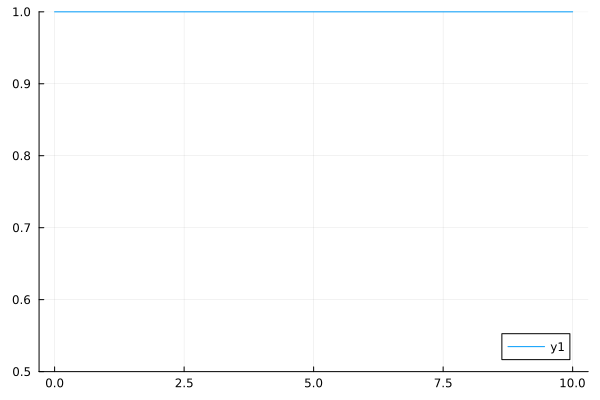

In [14]:
#Plotting
plot(times, traces, ylims=(0.5,1.0))

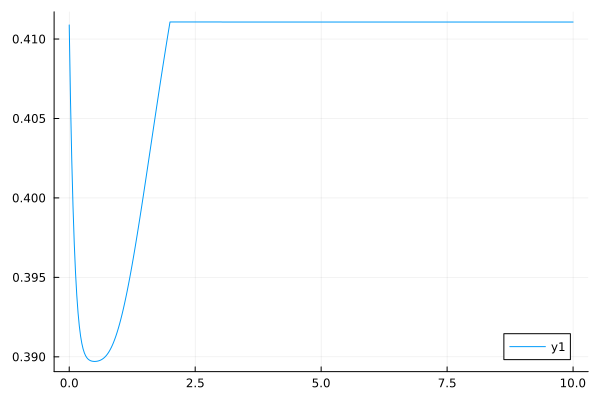

In [15]:
plot(times, traces2)

In [16]:
#Make array to hold expectations 
exp=zeros(length(times),N)im
for ii in 1:length(times)
    for jj in 1:N
        exp[ii,jj]=sig_z_exp(dens[:,:,ii],jj)
    end
end

In [18]:
colors = ["#014680", "#027fe4", "#66baff", "#8373e2
", "#884697", "#ba3f8b", "#ff72ad"]

# Basic plot with improvements
plot(times, real(exp[:,1]), label="Interface Qubit 1", linewidth=3, linestyle=:dash, color=colors[1])
plot!(times, real(exp[:,2]), label="Interface Qubit 2", linewidth=3, linestyle=:dash, color=colors[2])
plot!(times, real(exp[:,3]), label="Reservoir Qubit 1", linewidth=3, linestyle=:solid, color=colors[3])
plot!(times, real(exp[:,4]), label="Reservoir Qubit 2", linewidth=3, linestyle=:solid, color=colors[4])
plot!(times, real(exp[:,5]), label="Reservoir Qubit 3", linewidth=3, linestyle=:solid, color=colors[5])
plot!(times, real(exp[:,6]), label="Reservoir Qubit 4", linewidth=3, linestyle=:solid, color=colors[6])
plot!(times, real(exp[:,7]), label="Reservoir Qubit 5", linewidth=3, linestyle=:solid, color=colors[7])

# Add title, labels, and grid
xlabel!("Time", fontsize=16, fontweight="bold")
ylabel!("Excitation", fontsize=16, fontweight="bold")
title!("5 Qubit Reservoir with 2 Qubit Entangled Input", fontsize=18, fontweight="bold")

# Customize the legend
plot!(legend=:topright, legendfontsize=12)

# Increase tick font size and set aspect ratio
plot!(tickfontsize=14, size=(1000, 600))

savefig("reservoir_dynamics_plot.png")

"/Users/irvinc01/Innovation/QuantumReservoir/historic_code/reservoir_dynamics_plot.png"

In [17]:
excitation_df=DataFrame(Qubit1=real(exp[:,1]),
Qubit2=real(exp[:,2]),
Qubit3=real(exp[:,3]),
Qubit4=real(exp[:,4]),
Qubit5=real(exp[:,5]),
Qubit6=real(exp[:,6]))

Row,Qubit1,Qubit2,Qubit3,Qubit4,Qubit5,Qubit6
,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.126568,0.169886,-1.0,-1.0,-1.0,-1.0
2,-0.152454,0.144,-0.999801,-0.999888,-0.99995,-0.999801
3,-0.17632,0.120134,-0.999235,-0.99957,-0.999809,-0.999235
4,-0.198324,0.0981302,-0.998346,-0.99907,-0.999587,-0.998346
5,-0.218611,0.0778436,-0.997174,-0.99841,-0.999294,-0.997174
6,-0.237314,0.0591402,-0.995755,-0.997612,-0.998939,-0.995755
7,-0.254558,0.0418963,-0.994122,-0.996694,-0.99853,-0.994122
8,-0.270456,0.025998,-0.992304,-0.995671,-0.998076,-0.992304
9,-0.285114,0.0113404,-0.990328,-0.99456,-0.997582,-0.990328


# Generation of data

In [18]:
#Generate the training data
#Number of datapoints 
N=100
data=zeros(4,4,N)im
labels=zeros(2,N)

#Eigenvalue and linear entropy will both be computed as labels 
for ii in 1:convert(Int,N/4)
    temp=gen_separable(4)
    data[:,:,ii]=temp[1]
    labels[1,ii]=temp[2]
    labels[2,ii]=temp[3]
end
for ii in convert(Int, N/4):convert(Int,N/2)
    temp=gen_pure_separable(4)
    data[:,:,ii]=temp[1]
    labels[1,ii]=temp[2]
    labels[2,ii]=temp[3]
end
for ii in convert(Int,N/2):convert(Int,3N/4)
    temp=gen_entangled(4)
    data[:,:,ii]=temp[1]
    labels[1,ii]=temp[2]
    labels[2,ii]=temp[3]
end
for ii in convert(Int,3N/4):N
    temp=gen_pure_entangled(4)
    data[:,:,ii]=temp[1]
    labels[1,ii]=temp[2]
    labels[2,ii]=temp[3]
end

In [19]:
#Reservoir configuration
#Initialise the reservoir
reservoir=[[0,1],[0,1],[0,1],[0,1]]
gamma_C=[1,0.75,0.5,1]
interface=[1,1]
gamma_D=0.35*sum(gamma_C)
J_matrix=([0 1 0 0;
        1 0 1 0;
        0 1 0 1;
        0 0 1 0]) #Qubits interconnected on a chain

#Timing
dt=0.025
times1=collect(0:dt:2)
times2=collect(times1[end]:dt:2.5)
times=cat(times1,times2,dims=1)

102-element Vector{Float64}:
 0.0
 0.025
 0.05
 0.075
 0.1
 0.125
 0.15
 0.175
 0.2
 0.225
 0.25
 0.275
 0.3
 ⋮
 2.225
 2.25
 2.275
 2.3
 2.325
 2.35
 2.375
 2.4
 2.425
 2.45
 2.475
 2.5

In [20]:
times

102-element Vector{Float64}:
 0.0
 0.025
 0.05
 0.075
 0.1
 0.125
 0.15
 0.175
 0.2
 0.225
 0.25
 0.275
 0.3
 ⋮
 2.225
 2.25
 2.275
 2.3
 2.325
 2.35
 2.375
 2.4
 2.425
 2.45
 2.475
 2.5

In [ ]:
#Tensor to hold the excitations of each qubit for each interation of the reservoir
excitations=zeros(N, length(reservoir))

In [ ]:
#Generate
Threads.@threads for ii in tqdm(1:N)
    #Find the initial density matrix 
    rho0=total_rho(data[:,:,ii], reservoir)
    #find the cascade term 
    tensor_cascade=connect_interface(rho0, times1, gamma_C, gamma_D, interface) 
    #Allow reservoir dynamics after 
    tensor_hamiltonian=reservoir_dynamics(tensor_cascade[:,:,end], times2, J_matrix, interface) 
    #Measure the excitations each time 
    for jj in 1:length(reservoir)
        excitations[ii,jj]=sig_z_exp(tensor_hamiltonian[:,:,end], (jj+2))
    end
end

In [ ]:
scatter(ones(N), excitations[:,1])
scatter!(2*ones(N), excitations[:,2])
scatter!(3*ones(N), excitations[:,3])
scatter!(4*ones(N), excitations[:,4])

In [ ]:
#Write the data to a CSV file 
df = DataFrame(Negativity_Eigenvalue=labels[1,:],
    Linear_Entropy=labels[2,:],
    RQubit1=excitations[:,1],
RQubit2=excitations[:,2],
RQubit3=excitations[:,3],
RQubit4=excitations[:,4])

In [ ]:
#Export to CSV
CSV.write("4000_Julia_excitations.csv",df)

# Reservoir Size vs Accuracy 

Globals

In [ ]:
N_runs=500
t1=2
t2=2.5
dt0=0.025

Reservoir 1

Reservoir 2 

In [ ]:
excitations=reservoir_excitations(N_runs, [0 1;1 0], [1,1], 2, t1, t2, dt0, [[0,1],[0,1]], [1,1]) 
#Write the data to a CSV file 
df2 = DataFrame(Negativity_Eigenvalue=labels[1,:],
    Linear_Entropy=labels[2,:],
    RQubit1=excitations[:,1],
RQubit2=excitations[:,2])

#Export to CSV 
CSV.write("Reservoir2.csv",df2)

Reservoir 3

In [ ]:
excitations=reservoir_excitations(N_runs, [0 1 0;1 0 1;0 1 0], [1,1,1], 3, t1, t2, dt0, [[0,1],[0,1],[0,1]], [1,1]) 
#Write the data to a CSV file 
df3 = DataFrame(Negativity_Eigenvalue=labels[1,:],
    Linear_Entropy=labels[2,:],
    RQubit1=excitations[:,1],
RQubit2=excitations[:,2],
RQubit3=excitations[:,3])
#Export to CSV 
CSV.write("Reservoir3.csv",df3)

Reservoir 4

In [ ]:
excitations=reservoir_excitations(N_runs, [0 1 0 0;1 0 1 0;0 1 0 1; 0 0 1 0], [1,1,1,1], 4, t1, t2, dt0, [[0,1],[0,1],[0,1],[0,1]], [1,1]) 
#Write the data to a CSV file 
df4 = DataFrame(Negativity_Eigenvalue=labels[1,:],
    Linear_Entropy=labels[2,:],
    RQubit1=excitations[:,1],
RQubit2=excitations[:,2],
RQubit3=excitations[:,3],
RQubit4=excitations[:,4])

#Export to CSV 
CSV.write("Reservoir4.csv",df4)

Reservoir 5 

In [ ]:
excitations=reservoir_excitations(N_runs, [0 1 0 0 0;1 0 1 0 0;0 1 0 1 0; 0 0 1 0 1; 0 0 0 1 0], [1,1,1,1,1], 5, t1, t2, dt0, [[0,1],[0,1],[0,1],[0,1],[0,1]], [1,1]) 
#Write the data to a CSV file  
df5 = DataFrame(Negativity_Eigenvalue=labels[1,:],
    Linear_Entropy=labels[2,:],
    RQubit1=excitations[:,1],
RQubit2=excitations[:,2],
RQubit3=excitations[:,3],
RQubit4=excitations[:,4],
RQubit5=excitations[:,5])

#Export to CSV 
CSV.write("Reservoir5.csv",df5)

Reservoir 6

In [ ]:
excitations=reservoir_excitations(N_runs, [0 1 0 0 0 0; 1 0 1 0 0 0 ;0 1 0 1 0 0; 0 0 1 0 1 0; 0 0 0 1 0 1; 0 0 0 0 1 0],
    [1,1,1,1,1,1], 6, t1, t2, dt0, [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]], [1,1]) 
#Write the data to a CSV file  
df6 = DataFrame(Negativity_Eigenvalue=labels[1,:],
    Linear_Entropy=labels[2,:],
    RQubit1=excitations[:,1],
RQubit2=excitations[:,2],
RQubit3=excitations[:,3],
RQubit4=excitations[:,4],
RQubit5=excitations[:,5],
RQubit6=excitations[:,6])

#Export to CSV 
CSV.write("Reservoir6.csv",df6)